## Assignment 3 on Natural Language Processing

## Date : 30th Sept, 2020

### Instructor : Prof. Sudeshna Sarkar

### Teaching Assistants : Alapan Kuila, Aniruddha Roy, Anusha Potnuru, Uppada Vishnu

The central idea of this assignment is to use Naive Bayes classifier and LSTM based classifier and compare the models by accuracy on IMDB dataset.



In [ ]:
!pip install tensorflow==2.0.0-rc0

Please submit with outputs. 

In [2]:
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
#Load the IMDB dataset. You can load it using pandas as dataframe
dataset = pd.read_csv("IMDB Dataset.csv")
dataset

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# Preprocessing
PrePrecessing that needs to be done on lower cased corpus

1. Remove html tags
2. Remove URLS
3. Remove non alphanumeric character
4. Remove Stopwords
5. Perform stemming and lemmatization

You can use regex from re. 

In [6]:
nltk.download('punkt')
#all text to lowercase and remove unwanted signs 
def remove_unwanted_chars(text):
    allowed_chars = """ abcdefghijklmnopqrstuvwxyz;,!.?"""
    clean_text = text.lower()
    for c in clean_text:
        if allowed_chars.find(c) == -1:
            clean_text = clean_text.replace(c, "")
        else:
            pass
    return clean_text


def remove_html(text):    #removing HTML
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)


def remove_URL(text):  #removing URL
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", text)


def remove_stopwords(text, stop_words):  #removing stopwords
    filtered_sentence = []
    for w in text.split(" "): 
        if w not in stop_words: 
            filtered_sentence.append(w)
    text = " ".join(filtered_sentence)
    return text


def make_sentences_correct(text): #getting correct words
    val = re.split('[!.,?;\s]+', text)
    text = " ".join(val)
    return text             

def get_lemma(text): # getting lemmas
    word_tokens = word_tokenize(text)
    return " ".join(word_tokens)

                        
def remove_white_spaces(text): #removing whitespaces from start and end
    text = text.strip() 
    return text      


dataset["review"] = dataset.review.map(lambda x: remove_unwanted_chars(x))
dataset["review"] = dataset.review.map(lambda x: remove_URL(x))
dataset["review"] = dataset.review.map(lambda x: remove_html(x))
dataset["review"] = dataset.review.map(lambda x: remove_emoji(x))
dataset["review"] = dataset.review.map(lambda x: remove_stopwords(x, stop_words))
dataset["review"] = dataset.review.map(lambda x: make_sentences_correct(x))
dataset["review"] = dataset.review.map(lambda x: get_lemma(x))
dataset["review"] = dataset.review.map(lambda x: remove_white_spaces(x))

dataset

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,review,sentiment
0,one reviewers mentioned watching oz episode yo...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive
...,...,...
49995,thought movie right good job wasnt creative or...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary schools n...,negative
49998,im going disagree previous comment side maltin...,negative


Distribution of two classes: 
sentiment
negative    25000
positive    25000
Name: sentiment, dtype: int64
Average number of words in each document:  126.7472
Plot showing number of words variation in documents: 


<BarContainer object of 50000 artists>

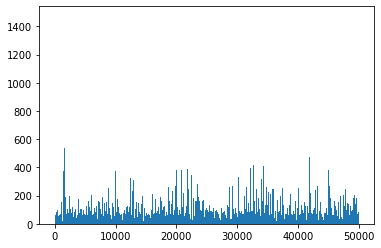

In [7]:
# Print Statistics of Data like avg length of sentence , proposition of data w.r.t class labels
print("Distribution of two classes: ")
print(dataset.groupby("sentiment").sentiment.count())

count = 0
word_count = []
for i in range(50000):
    temp = len(dataset.iloc[i]["review"].split(" "))
    word_count.append(temp)
    count+=temp

print("Average number of words in each document: ", count/dataset.shape[0])
print("Plot showing number of words variation in documents: ")
plt.bar(np.arange(50000), word_count, width=1)

# Naive Bayes classifier

In [8]:
# get reviews column from df
reviews = dataset["review"]

# get labels column from df
labels = dataset["sentiment"]

In [9]:
# Use label encoder to encode labels. Convert to 0/1
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [10]:
# Split the data into train and test (80% - 20%). 
# Use stratify in train_test_split so that both train and test have similar ratio of positive and negative samples.

X_train, X_test, y_train, y_test = train_test_split(reviews, encoded_labels, test_size=0.2, random_state=0, stratify=encoded_labels)
print("length of training dataset:", len(X_train.index))
print("length of testing dataset:", len(X_test.index))
print("*******First sentence in train dataset*********")
print(X_train[0])
print("*******First sentence class in test dataset*********")
print(y_train[0])

length of training dataset: 40000
length of testing dataset: 10000
*******First sentence in train dataset*********
one reviewers mentioned watching oz episode youll hooked right exactly happened me br br first thing struck oz brutality unflinching scenes violence set right word go trust me show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word br br called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish more so scuffles death stares dodgy dealings shady agreements never far away br br would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romance oz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready it watched more developed taste oz got accustome

In [11]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000,)
(10000,)
(40000,)
(10000,)


Here there are two approaches possible for building vocabulary for the naive Bayes.
1. Take the whole data (train + test) to build the vocab. In this way while testing there is no word which will be out of vocabulary.
2. Take the train data to build vocab. In this case, some words from the test set may not be in vocab and hence one needs to perform smoothing so that one the probability term is not zero.
 
You are supposed to go by the 2nd approach.
 
Also building vocab by taking all words in the train set is memory intensive, hence you are required to build vocab by choosing the top 2000 - 3000 frequent words in the training corpus.

> $ P(x_i | w_j) = \frac{ N_{x_i,w_j}\, +\, \alpha }{ N_{w_j}\, +\, \alpha*d} $


$N_{x_i,w_j}$ : Number of times feature $x_i$ appears in samples of class $w_j$

$N_{w_j}$ : Total count of features in class $w_j$

$\alpha$ : Parameter for additive smoothing. Here consider $\alpha$ = 1

$d$ : Dimentionality of the feature vector  $x = [x_1,x_2,...,x_d]$. In our case its the vocab size.






In [12]:
from sklearn.feature_extraction.text import CountVectorizer

#term document matrix for class 1
docs_1 = [X_train[i] for i in X_train.index if encoded_labels[i] == 1]
vec_1 = CountVectorizer(max_features=3000)
X_1 = vec_1.fit_transform(docs_1)

#term document matrix for class 0
docs_0 = [X_train[i] for i in X_train.index if encoded_labels[i] == 0]
vec_0 = CountVectorizer(max_features=3000)
X_0 = vec_0.fit_transform(docs_0)

#frequency of each word in class 1
word_list_1 = vec_1.get_feature_names();    
count_list_1 = X_1.toarray().sum(axis=0) 
freq_1 = dict(zip(word_list_1,count_list_1))

#frequency of each word in class 0
word_list_0 = vec_0.get_feature_names();    
count_list_0 = X_0.toarray().sum(axis=0) 
freq_0 = dict(zip(word_list_0,count_list_0))

#total count of features in class 1
total_cnts_features_1 = count_list_1.sum(axis=0)
print(total_cnts_features_1)

#total count of features in class 0
total_cnts_features_0 = count_list_0.sum(axis=0)
print(total_cnts_features_0)

1896932
1916509


In [13]:
# predicting the probalility of words using laplace smoothing for class 1
prob_1_with_ls = []
for sent in X_test:
    prob = 1
    for word in sent.split():
        if word in freq_1.keys():
            count = freq_1[word]
        else:
            count = 0
        prob *= (count + 1)/(total_cnts_features_1 + 3000)
    prob_1_with_ls.append(prob)
    
# predicting the probalility of words using laplace smoothing for class 0
prob_0_with_ls = []
for sent in X_test:
    prob = 1
    for word in sent.split():
        if word in freq_0.keys():
            count = freq_0[word]
        else:
            count = 0
        prob *= (count + 1)/(total_cnts_features_0 + 3000)
    prob_0_with_ls.append(prob)
    

# predicting the classes of sentences in the test data
y_test_pred = []
for i in range(len(prob_0_with_ls)):
    if prob_0_with_ls[i]>prob_1_with_ls[i]:
        y_test_pred.append(0)
    else:
        y_test_pred.append(1)

In [14]:
# Test the model on test set and report Accuracy
correct = 0
for i in range(len(y_test_pred)):
    if y_test[i] == y_test_pred[i]:
        correct+=1
print("Obtained accuracy using Naive Bayes Classifier is:", (correct*100)/len(y_test))

Obtained accuracy using Naive Bayes Classifier is: 63.93


# *LSTM* based Classifier

Use the above train and test splits.

In [15]:
# Hyperparameters of the model
vocab_size = 3000
oov_tok = '<OOK>'
embedding_dim = 100
max_length = 180
padding_type='post'
trunc_type='post'

In [16]:
# splitting the data 
train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, test_size=0.2, random_state=0, stratify=encoded_labels)

# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)

# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

In [17]:
# model initialization
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')])

# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 180, 100)          300000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 24)                3096      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 387,601
Trainable params: 387,601
Non-trainable params: 0
_________________________________________________________________


In [18]:
num_epochs = 5
history = model.fit(train_padded, train_labels, epochs=num_epochs, verbose=1, validation_split=0.1)

Train on 36000 samples, validate on 4000 samples
Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
36000/36000 [==============================] - 261s 7ms/sample - loss: 0.3855 - accuracy: 0.8269 - val_loss: 0.3128 - val_accuracy: 0.8755
Epoch 2/5
36000/36000 [==============================] - 261s 7ms/sample - loss: 0.2837 - accuracy: 0.8856 - val_loss: 0.3031 - val_accuracy: 0.8723
Epoch 3/5
36000/36000 [==============================] - 261s 7ms/sample - loss: 0.2483 - accuracy: 0.9019 - val_loss: 0.3089 - val_accuracy: 0.8730
Epoch 4/5
36000/36000 [==============================] - 264s 7ms/sample - loss: 0.2186 - accuracy: 0.9161 - val_loss: 0.3145 - val_accuracy: 0.8725
Epoch 5/5
36000/36000 [==============================] - 261s 7ms/sample - loss: 0.2059 - accuracy: 0.9201 - val_loss: 0.3397 - val_accuracy: 0.8560


In [19]:
# Calculate accuracy on Test data
prediction = model.predict(test_padded)

# Get labels based on probability 1 if p>= 0.5 else 0
predicted_test = []
for item in prediction:
  if item >= 0.5:
    predicted_test.append(1)
  else:
    predicted_test.append(0)

# Accuracy : one can use classification_report from sklearn
correct = 0
for i in range(len(predicted_test)):
  if predicted_test[i] == test_labels[i]:
    correct+=1

print("Accuracy of the model on the test data is:", (correct*100)/len(predicted_test))

Accuracy of the model on the test data is: 85.5


## Get predictions for random examples

In [20]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming", 
            "I have never seen a terrible movie like this", 
            "the movie plot is terrible but it had good acting"]

# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# pad the sequence
padded = pad_sequences(sequences, padding='post', maxlen=max_length)

# Get probabilities
print(model.predict(padded))

# Get labels based on probability 1 if p>= 0.5 else 0

predicted_examples = []
for item in model.predict(padded):
  if item >= 0.5:
    predicted_examples.append(1)
  else:
    predicted_examples.append(0)

print(predicted_examples)

[[0.79820657]
 [0.22194049]
 [0.05066691]]
[1, 0, 0]
